In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import random
import warnings

# Machine Learning and Deep Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback

# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Genetic Algorithm Libraries
import deap
from deap import base, creator, tools, algorithms

In [19]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [20]:
class QuietEpochTimeCallback(Callback):
    """
    Custom callback to track epoch training times with minimal logging
    """
    def __init__(self):
        super().__init__()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - self.epoch_start_time
        self.epoch_times.append(epoch_time)

class StrokeModelOptimizer:
    def __init__(self, filepath):
        """
        Initialize the optimizer with data and genetic algorithm parameters
        
        Parameters:
        -----------
        filepath : str
            Path to the stroke prediction dataset
        """
        # Data Loading and Preprocessing
        self.X_train, self.X_test, self.y_train, self.y_test, self.scaler = self.load_and_preprocess_data(filepath)
        
        # GA Configuration
        self.POPULATION_SIZE = 10
        self.MAX_GENERATIONS = 10
        self.CROSSOVER_PROB = 0.7
        self.MUTATION_PROB = 0.2
        
        # Chromosome Gene Ranges with Explicit Constraints
        self.GENE_CONFIGS = {
            'neurons_layer1': (16, 128),   # First layer neurons
            'neurons_layer2': (8, 64),     # Second layer neurons
            'dropout_rate1': (0.1, 0.5),   # First dropout rate
            'dropout_rate2': (0.1, 0.3),   # Second dropout rate
            'learning_rate': (1e-4, 1e-2), # Learning rate
            'l2_reg': (1e-4, 1e-2)         # L2 regularization strength
        }
        
        # Optimization Constraints
        self.CONSTRAINTS = {
            'min_accuracy': 0.75,
            'max_false_negative_rate': 0.2,
            'min_recall': 0.7,
            'max_training_time': 300,  # 5 minutes
            'max_total_params': 10000
        }
        
        # Setup DEAP framework
        self.setup_deap_framework()
        
    def load_and_preprocess_data(self, filepath):
        """
        Load and preprocess stroke prediction dataset
        """
        df = pd.read_csv(filepath)
        X = df.drop('stroke', axis=1)
        y = df['stroke']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        return X_train_scaled, X_test_scaled, y_train, y_test, scaler
    
    def setup_deap_framework(self):
        """
        Setup DEAP's multi-objective optimization framework
        """
        # Multi-objective maximization problem
        creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0, 1.0))
        creator.create("Individual", list, fitness=creator.FitnessMulti)
        
        # Toolbox setup
        self.toolbox = base.Toolbox()
        
        # Gene generation functions
        for gene, (low, high) in self.GENE_CONFIGS.items():
            self.toolbox.register(f"attr_{gene}", random.uniform, low, high)
        
        # Individual and population creation
        self.toolbox.register("individual", 
                               tools.initCycle, 
                               creator.Individual,
                               (self.toolbox.attr_neurons_layer1, 
                                self.toolbox.attr_neurons_layer2,
                                self.toolbox.attr_dropout_rate1,
                                self.toolbox.attr_dropout_rate2,
                                self.toolbox.attr_learning_rate,
                                self.toolbox.attr_l2_reg), 
                               n=1)
        
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        
        # Genetic Operators
        self.toolbox.register("evaluate", self.evaluate_individual)
        self.toolbox.register("mate", tools.cxBlend, alpha=0.5)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
        self.toolbox.register("select", tools.selNSGA2)
        
    def create_ann_model(self, individual):
        """
        Create ANN model with explicit constraints
        """
        neurons_layer1, neurons_layer2, dropout1, dropout2, learning_rate, l2_reg = individual

        # Constraint Checks
        neurons_layer1 = max(16, min(128, int(neurons_layer1)))
        neurons_layer2 = max(8, min(64, int(neurons_layer2)))
        dropout1 = max(0.1, min(0.5, dropout1))
        dropout2 = max(0.1, min(0.3, dropout2))
        learning_rate = max(1e-4, min(1e-2, learning_rate))
        l2_reg = max(1e-4, min(1e-2, l2_reg))

        model = Sequential([
            Dense(neurons_layer1, activation='relu', 
                  input_shape=(self.X_train.shape[1],), 
                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
            Dropout(dropout1),
            Dense(neurons_layer2, activation='relu', 
                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
            Dropout(dropout2),
            Dense(1, activation='sigmoid')
        ])

        # Check total model parameters
        total_params = sum([layer.count_params() for layer in model.layers])
        if total_params > self.CONSTRAINTS['max_total_params']:
            raise ValueError("Model exceeds maximum parameter constraint")

        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model
    
    def train_model(self, model, X_train, y_train):
        """
        Train model with minimal logging
        """
        epochs = 5
        
        # Epoch time tracking callback
        epoch_time_callback = QuietEpochTimeCallback()
        
        # Early stopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=epochs,
            batch_size=64,
            callbacks=[
                early_stopping,
                epoch_time_callback
            ],
            verbose=0  # Completely silent training
        )
        
        return history, epoch_time_callback
    
    def evaluate_individual(self, individual):
        """
        Enhanced evaluation with performance constraints
        """
        try:
            # Create and train model
            model = self.create_ann_model(individual)
            start_time = time.time()
            
            history, epoch_time_callback = self.train_model(
                model, self.X_train, self.y_train
            )
            
            training_time = time.time() - start_time
            
            # Performance Metrics with Constraint Checks
            y_pred_proba = model.predict(self.X_test, verbose=0)
            y_pred = (y_pred_proba > 0.5).astype(int)
            
            accuracy = accuracy_score(self.y_test, y_pred)
            recall = recall_score(self.y_test, y_pred)
            false_negative_rate = np.sum((y_pred == 0) & (self.y_test == 1)) / np.sum(self.y_test == 1)
            
            # Constraint Validation
            if (accuracy < self.CONSTRAINTS['min_accuracy'] or 
                recall < self.CONSTRAINTS['min_recall'] or 
                false_negative_rate > self.CONSTRAINTS['max_false_negative_rate'] or 
                training_time > self.CONSTRAINTS['max_training_time']):
                return 1.0, float('inf'), float('inf'), 0.0
            
            return (
                false_negative_rate,    # Minimize
                training_time,           # Minimize
                model.count_params(),    # Minimize
                accuracy                 # Maximize
            )
        except Exception as e:
            print(f"Evaluation Error: {e}")
            return 1.0, float('inf'), float('inf'), 0.0
        
    def run_optimization(self):
        """
        Run multi-objective genetic algorithm optimization with minimal logging
        """
        # Initialize population
        population = self.toolbox.population(n=self.POPULATION_SIZE)
        
        # Hall of Fame to track best solutions
        hall_of_fame = tools.ParetoFront()
        
        # Create statistics tracker
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean, axis=0)
        stats.register("min", np.min, axis=0)
        
        # Run NSGA-II algorithm with reduced verbosity
        population, logbook = algorithms.eaMuPlusLambda(
            population, 
            self.toolbox, 
            mu=self.POPULATION_SIZE, 
            lambda_=self.POPULATION_SIZE, 
            cxpb=self.CROSSOVER_PROB, 
            mutpb=self.MUTATION_PROB, 
            stats=stats,
            halloffame=hall_of_fame, 
            ngen=self.MAX_GENERATIONS,
            verbose=False  # Minimize console output
        )
        
        return hall_of_fame, population, logbook

    def visualize_optimization_results(self, hall_of_fame, logbook):
        """
        Visualization of genetic algorithm optimization process
        """
        plt.figure(figsize=(20, 15))
        
        # 1. Pareto Front Visualization
        plt.subplot(2, 2, 1)
        pareto_front = np.array([ind.fitness.values for ind in hall_of_fame])
        plt.scatter(pareto_front[:, 0], pareto_front[:, 1], 
                    c=pareto_front[:, 3], cmap='viridis')
        plt.title('Pareto Front: False Negative Rate vs Training Time')
        plt.xlabel('False Negative Rate')
        plt.ylabel('Training Time')
        plt.colorbar(label='Accuracy')
        
        # 2. Convergence Plot
        plt.subplot(2, 2, 2)
        gen_stats = logbook.select("gen")
        avg_fitness = logbook.select("avg")
        plt.plot(gen_stats, [x[0] for x in avg_fitness], label='Avg False Negative Rate')
        plt.plot(gen_stats, [x[1] for x in avg_fitness], label='Avg Training Time')
        plt.title('Optimization Convergence')
        plt.xlabel('Generations')
        plt.ylabel('Metric Value')
        plt.legend()
        
        # 3. Best Individual Performance Tracking
        plt.subplot(2, 2, 3)
        best_individuals = [ind for ind in hall_of_fame]
        metrics = np.array([ind.fitness.values for ind in best_individuals])
        metrics_names = ['False Negative Rate', 'Training Time', 'Model Complexity', 'Accuracy']
        
        for i in range(4):
            plt.plot(metrics[:, i], label=metrics_names[i])
        plt.title('Best Individual Metrics Progression')
        plt.xlabel('Pareto Solutions')
        plt.ylabel('Metric Value')
        plt.legend()
        
        # 4. Distribution of Hyperparameters
        plt.subplot(2, 2, 4)
        hyperparams = np.array([list(ind)[:4] for ind in hall_of_fame])
        param_names = list(self.GENE_CONFIGS.keys())[:4]
        for i in range(4):
            plt.hist(hyperparams[:, i], bins=20, alpha=0.5, label=param_names[i])
        plt.title('Hyperparameter Distribution')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
    def visualize_epoch_training_times(self, epoch_times):
        """
        Visualize epoch training times
        """
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(epoch_times) + 1), epoch_times, marker='o')
        plt.title('Epoch Training Times')
        plt.xlabel('Epoch')
        plt.ylabel('Training Time (seconds)')
        plt.tight_layout()
        plt.show()

    def visualize_best_model_performance(self, best_model, X_test, y_test):
        """
        Comprehensive model performance visualization
        """
        plt.figure(figsize=(20, 10))
        
        # Predictions
        y_pred_proba = best_model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # 1. Confusion Matrix
        plt.subplot(2, 2, 1)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        
        # 3. ROC Curve
        plt.subplot(2, 3, 3)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        
        # 4. Precision-Recall Curve
        plt.subplot(2, 3, 4)
        from sklearn.metrics import precision_recall_curve, average_precision_score
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)
        plt.step(recall, precision, color='b', alpha=0.2, where='post')
        plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve (AP = {avg_precision:.2f})')
        
        # 5. Distribution of Predictions
        plt.subplot(2, 3, 5)
        plt.hist([y_pred_proba[y_test == 0], y_pred_proba[y_test == 1]], 
                 label=['Negative', 'Positive'], 
                 color=['blue', 'red'], 
                 alpha=0.6, 
                 bins=30)
        plt.title('Distribution of Prediction Probabilities')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Frequency')
        plt.legend()
        
        # 6. Prediction Error Analysis
        plt.subplot(2, 3, 6)
        prediction_errors = np.abs(y_test - y_pred_proba.ravel())
        plt.hist(prediction_errors, bins=30, color='green', alpha=0.7)
        plt.title('Prediction Error Distribution')
        plt.xlabel('Absolute Prediction Error')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()

def main():
    """
    Main function to run the stroke prediction model optimization
    """
    # Replace with your actual dataset path
    filepath = r'C:\Users\HP\Documents\GitHub\ci-coursework\cleaned-stroke-prediction-dataset-balanced.csv'
    
    # Initialize the optimizer
    optimizer = StrokeModelOptimizer(filepath)
    
    # Run multi-objective optimization
    hall_of_fame, population, logbook = optimizer.run_optimization()
    
    # Visualize optimization results
    optimizer.visualize_optimization_results(hall_of_fame, logbook)
    
    # Select the best individual (first in the Pareto front)
    best_individual = hall_of_fame[0]
    
    # Create and train the best model
    best_model = optimizer.create_ann_model(best_individual)
    
    # Train the model and get epoch times
    history, epoch_time_callback = optimizer.train_model(
        best_model, optimizer.X_train, optimizer.y_train
    )
    
    # Visualize epoch training times
    optimizer.visualize_epoch_training_times(epoch_time_callback.epoch_times)
    
    # Visualize best model performance
    optimizer.visualize_best_model_performance(best_model, optimizer.X_test, optimizer.y_test)
    
    # Save the best model using pickle
    with open('best_stroke_prediction_model.pkl', 'wb') as f:
        pickle.dump({
            'model': best_model,
            'scaler': optimizer.scaler
        }, f)
    print("Best model and scaler saved successfully!")

    # Optional: Load the model later
    # with open('best_stroke_prediction_model.pkl', 'rb') as f:
    #     saved_data = pickle.load(f)
    #     loaded_model = saved_data['model']
    #     loaded_scaler = saved_data['scaler']

Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
Evaluation Error: cannot reshape array

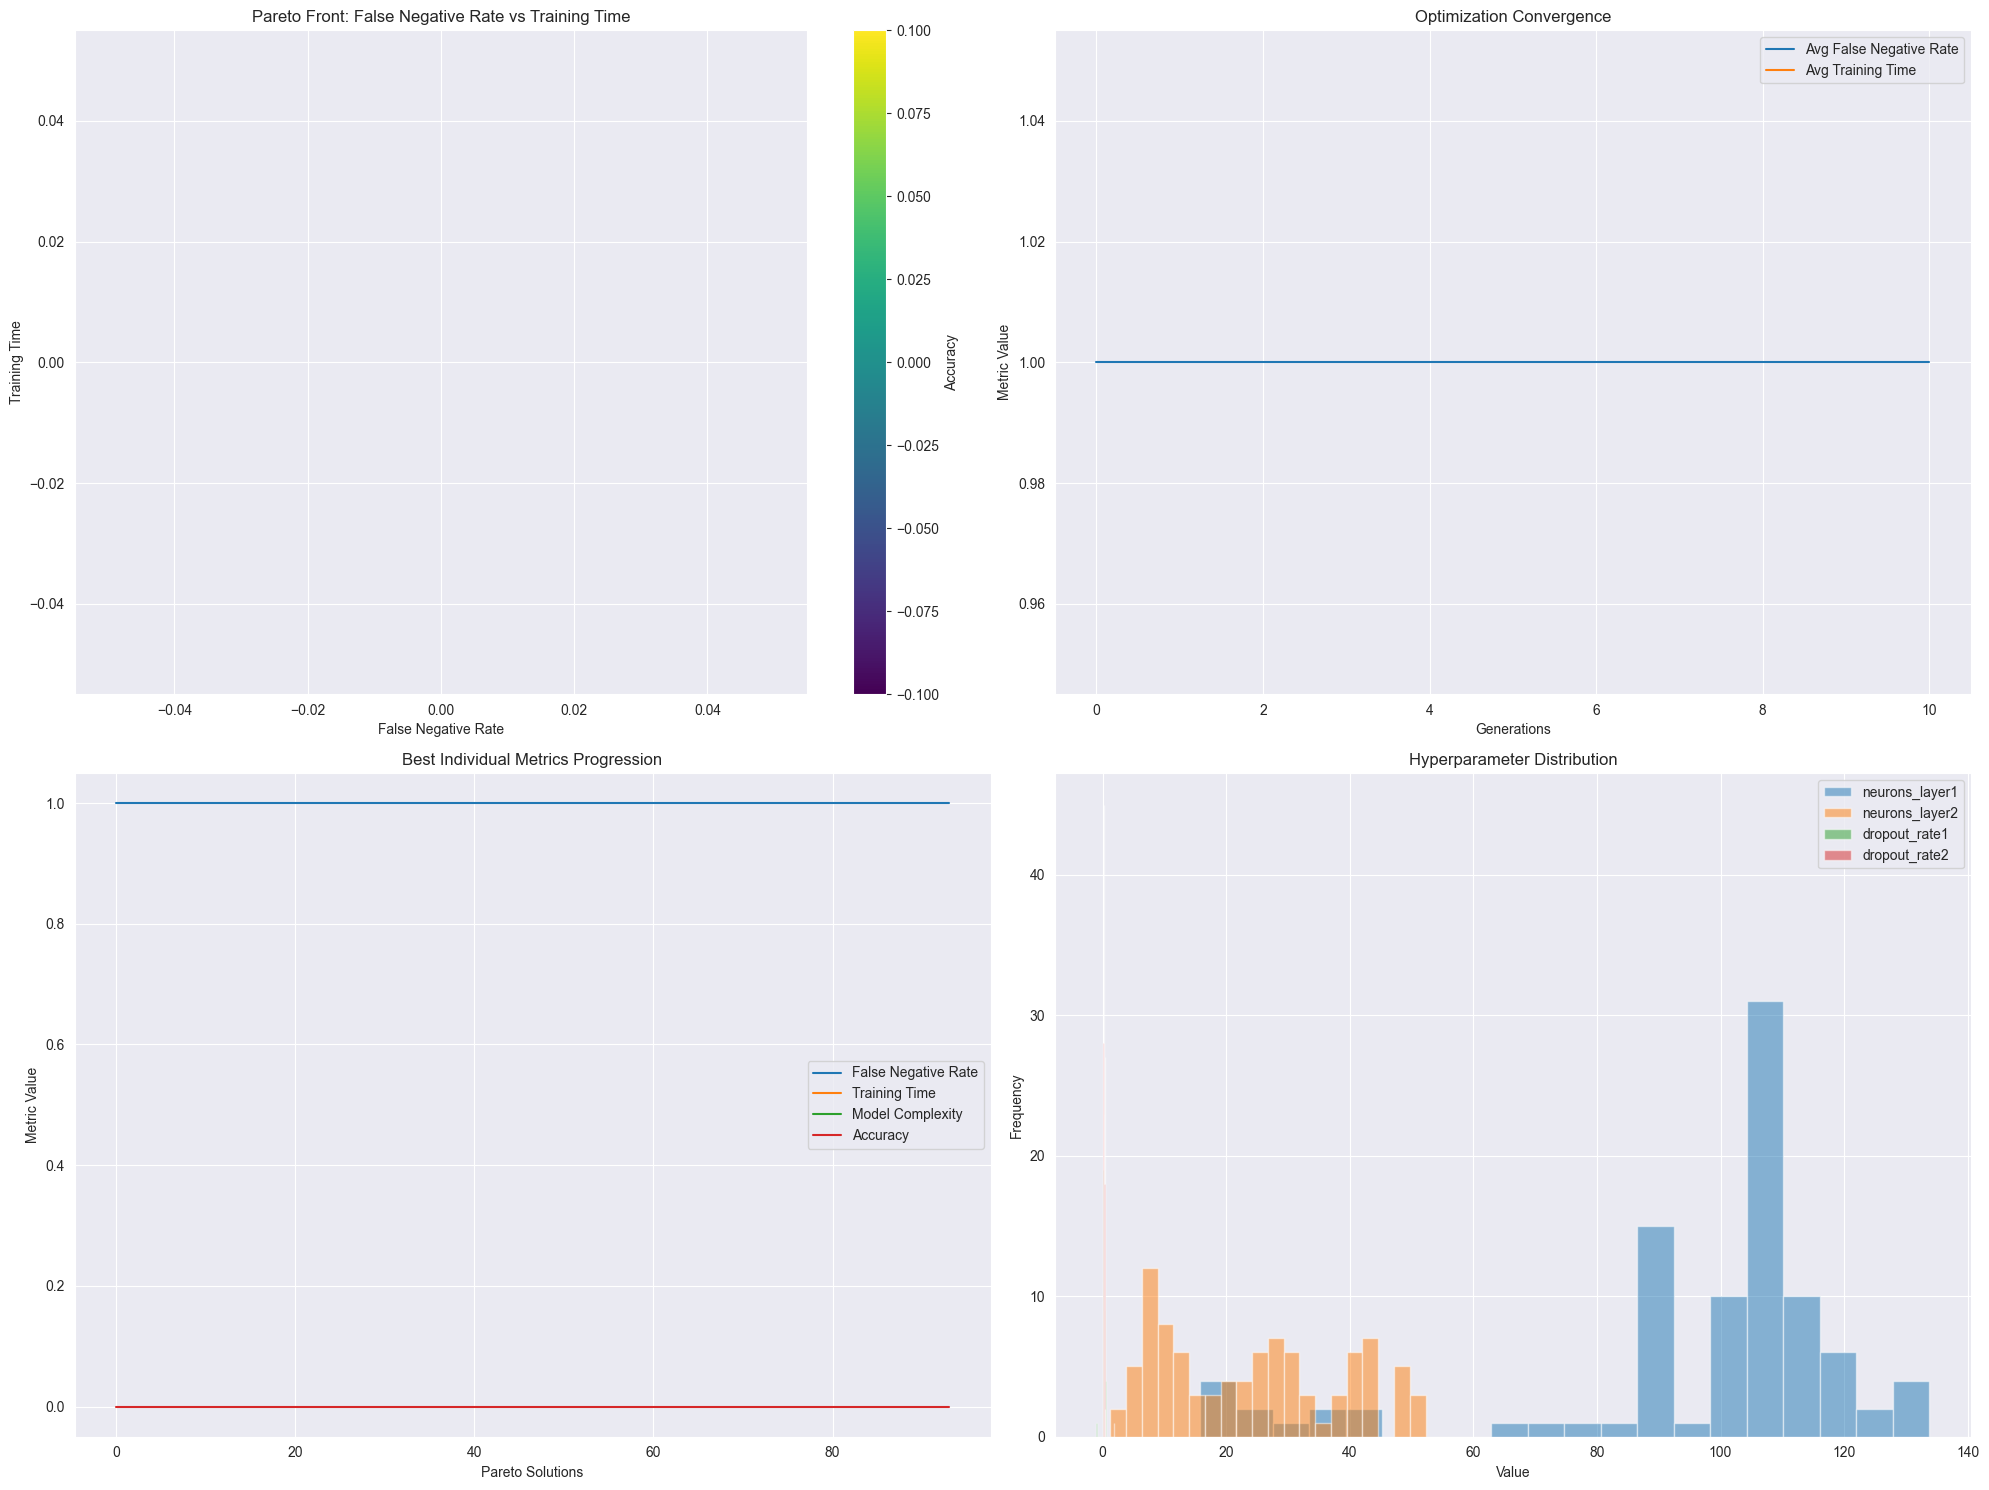

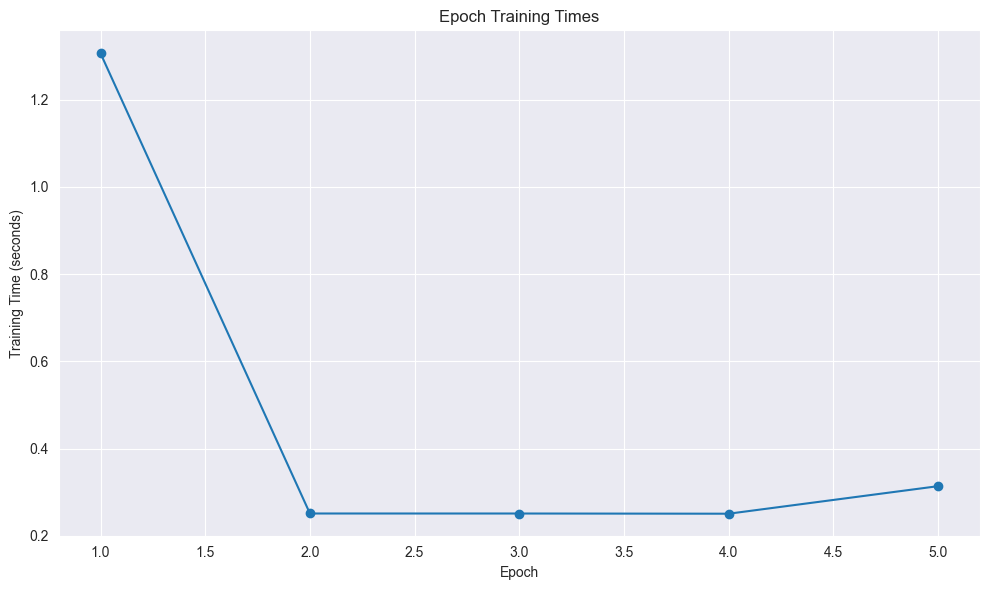

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       940
           1       0.91      0.90      0.90       940

    accuracy                           0.90      1880
   macro avg       0.90      0.90      0.90      1880
weighted avg       0.90      0.90      0.90      1880


ValueError: x must have 2 or fewer dimensions

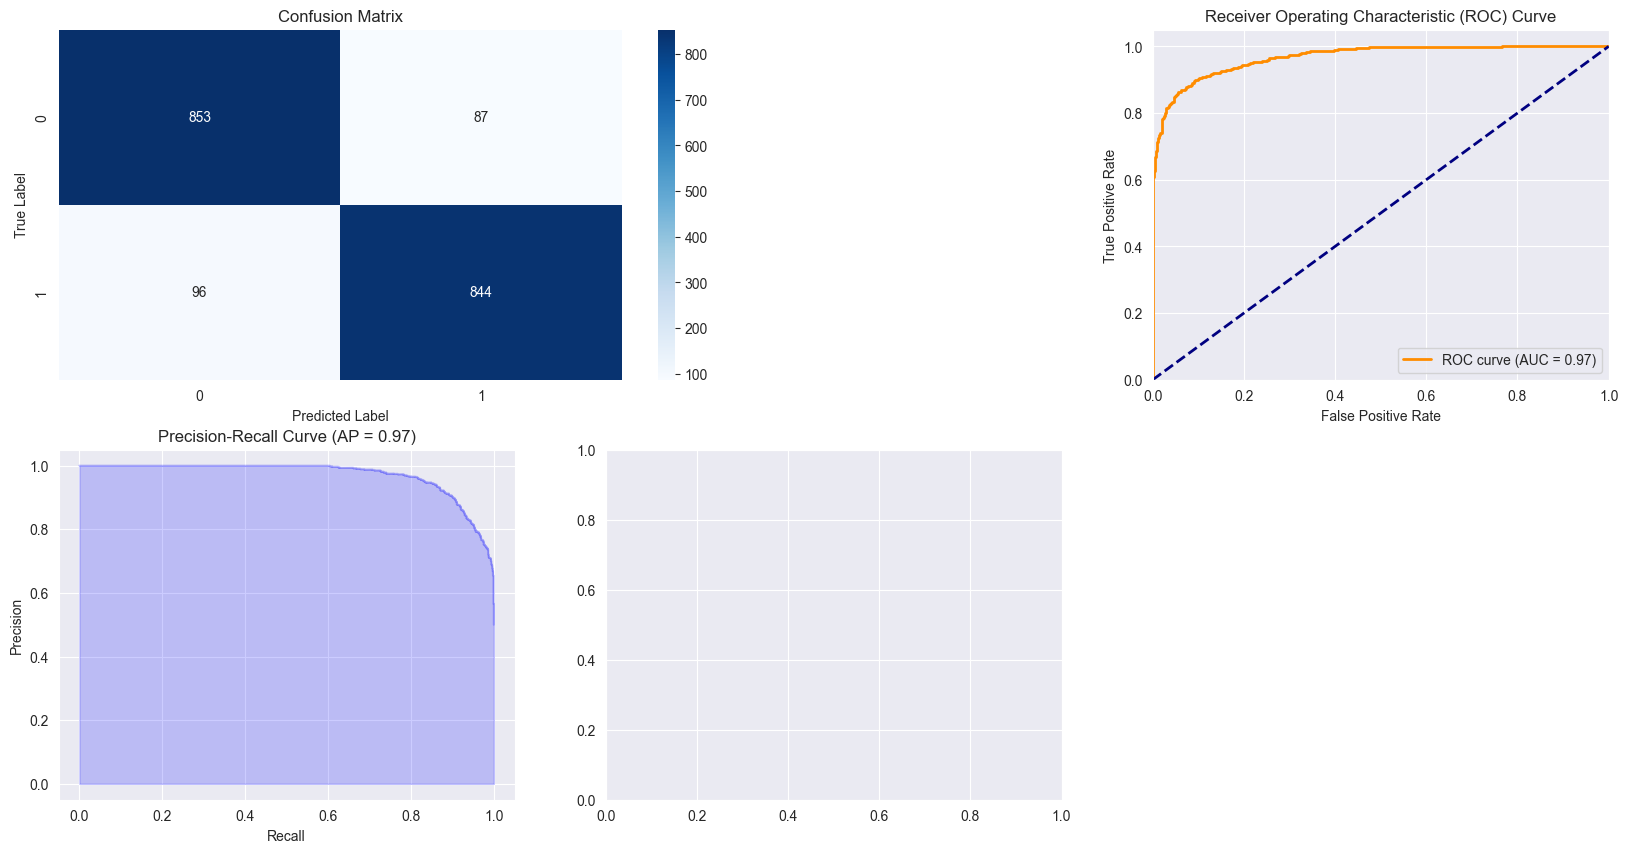

In [21]:
if __name__ == "__main__":
    main()P